- LSTM Autoencoder를 활용하여 PM2.5 시계열 데이터 이상치 탐지
- 기존의 DTW 이용해 두 시계열 구간의 패턴 유사도 추가 분석

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from dtaidistance import dtw
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector

# 1. 데이터 로드 & 전처리

In [3]:
# UCI의 Beijing PM2.5 Data (2010~2014)를 사용합니다.
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv"
air_df = pd.read_csv(url)

In [4]:
# datetime 생성 및 정렬
air_df['date_time'] = pd.to_datetime(air_df[['year', 'month', 'day', 'hour']])
air_df = air_df.sort_values(by='date_time')

In [5]:
# PM2.5 컬럼 결측치 처리 (평균 대체)
air_df['pm2.5'] = air_df['pm2.5'].fillna(air_df['pm2.5'].mean())

In [6]:
air_df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,date_time
0,1,2010,1,1,0,98.613215,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
1,2,2010,1,1,1,98.613215,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2,3,2010,1,1,2,98.613215,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
3,4,2010,1,1,3,98.613215,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
4,5,2010,1,1,4,98.613215,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.000000,-23,-2.0,1034.0,NW,231.97,0,0,2014-12-31 19:00:00
43820,43821,2014,12,31,20,10.000000,-22,-3.0,1034.0,NW,237.78,0,0,2014-12-31 20:00:00
43821,43822,2014,12,31,21,10.000000,-22,-3.0,1034.0,NW,242.70,0,0,2014-12-31 21:00:00
43822,43823,2014,12,31,22,8.000000,-22,-4.0,1034.0,NW,246.72,0,0,2014-12-31 22:00:00


# 2. 시계열 데이터 정규화 및 시퀀스 생성

In [7]:
scaler = MinMaxScaler()
pm25_scaled = scaler.fit_transform(air_df[['pm2.5']])

In [8]:
# 시퀀스 생성 함수 (24시간 단위의 시퀀스)
def create_sequence(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        seq = data[i:i+window_size]
        sequences.append(seq)
    return np.array(sequences)

window_size = 24  # 24시간 단위
sequences = create_sequence(pm25_scaled, window_size)
print("생성된 시퀀스 shape:", sequences.shape)  # (샘플 수, window_size, 1)

생성된 시퀀스 shape: (43800, 24, 1)


# 3. LSTM Autoencoder 모델 구성

In [9]:
timesteps = window_size
n_features = 1

In [10]:
# 인코더
input_layer = Input(shape=(timesteps, n_features))
encoded = LSTM(64, activation='relu', return_sequences=True)(input_layer)
encoded = LSTM(32, activation='relu')(encoded)

In [11]:
# 디코더
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoded)

In [12]:
# Autoencoder 모델
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 24, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 24, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 24, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,529 (244.25 KB)

 Trainable params: 62,529 (244.25 KB)

 Non-trainable params: 0 (0.00 B)

# 4. 모델 학습

In [13]:
# 전체 데이터 중 80%를 학습 데이터로 사용
train_size = int(0.8 * sequences.shape[0])
train_sequences = sequences[:train_size]
test_sequences = sequences[train_size:]

history = autoencoder.fit(train_sequences, train_sequences,
                          epochs=20,
                          batch_size=64,
                          validation_split=0.1,
                          shuffle=True)

Epoch 1/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.0044 - val_loss: 0.0012
Epoch 2/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - loss: 0.0013 - val_loss: 7.1984e-04
Epoch 3/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 8.1267e-04 - val_loss: 5.8600e-04
Epoch 4/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 6.9344e-04 - val_loss: 5.6456e-04
Epoch 5/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 6.8796e-04 - val_loss: 4.8610e-04
Epoch 6/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - loss: 5.6733e-04 - val_loss: 3.9099e-04
Epoch 7/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 4.9932e-04 - val_loss: 3.7345e-04
Epoch 8/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 4.7734e-04 - val_loss: 3.5792e-04
Epoch 9/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 4.6719e-04 - val_loss: 3.5481e-04
Epoch 10/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 4.7890e-04 - val_loss: 3.4498e-04
Epoch 11/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/s

# 5. 이상치 탐지: 재구성 오차(Reconstruction Error) 계산

In [14]:
reconstructed = autoencoder.predict(sequences)
reconstruction_errors = np.mean(np.abs(reconstructed - sequences), axis=(1, 2))

1369/1369 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step


In [15]:
# 재구성 오차 기준을 이용하여 임계치(threshold) 설정 (95번째 백분위수)
threshold = np.percentile(reconstruction_errors, 95)
print("재구성 오차 임계치:", threshold)

재구성 오차 임계치: 0.02512443195652521


In [16]:
# 각 시퀀스가 이상치인지 여부 (True: 이상치)
anomaly_flags = reconstruction_errors > threshold

In [17]:
# 시퀀스 단위 결과를 원본 데이터에 매핑하기 위해, 각 시퀀스의 마지막 인덱스 사용
anomaly_indices = np.where(anomaly_flags)[0] + window_size  # 시퀀스의 끝 인덱스

# 6. DTW를 활용한 시계열 패턴 분석

In [18]:
# 예시로, 정상 구간과 이상 구간 중 하나씩 선택하여 DTW 거리 계산
# 정상 구간: reconstruction error가 낮은 첫번째 시퀀스
normal_seq = sequences[np.argmin(reconstruction_errors)].flatten()
# 이상 구간: reconstruction error가 높은 첫번째 시퀀스
anomaly_seq = sequences[np.argmax(reconstruction_errors)].flatten()

dtw_distance = dtw.distance(normal_seq, anomaly_seq)
print("정상 구간과 이상 구간의 DTW distance:", dtw_distance)

정상 구간과 이상 구간의 DTW distance: 1.2763160942316214


# 7. 결과 시각화

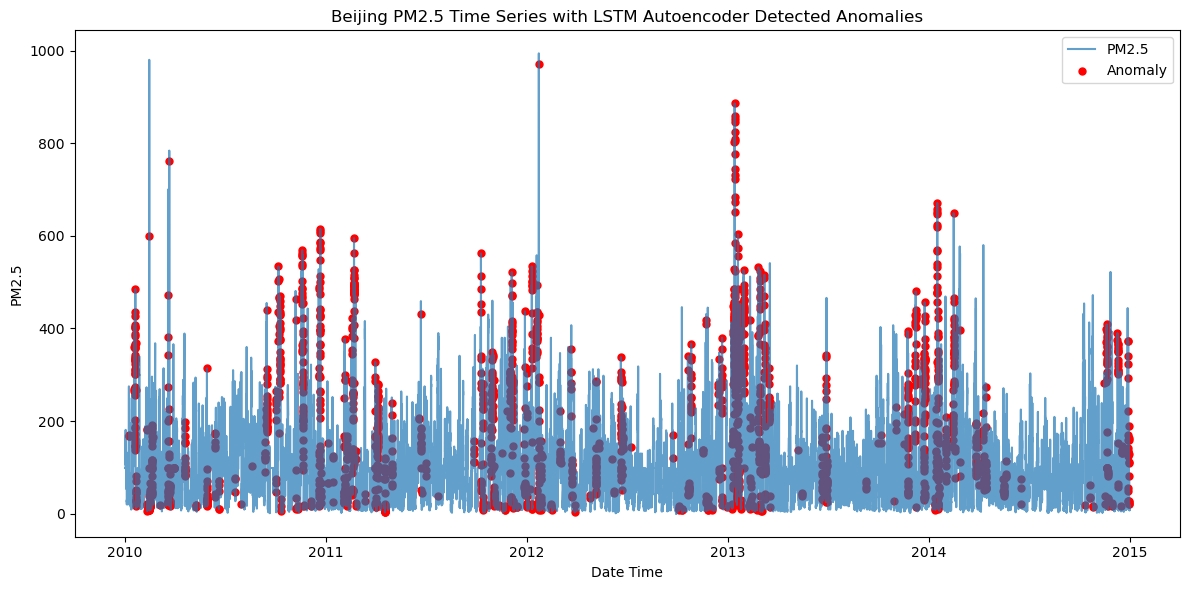

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(air_df['date_time'], air_df['pm2.5'], label='PM2.5', alpha=0.7)

# 이상치 표시: 각 시퀀스의 마지막 시점을 이상치로 표시
plt.scatter(air_df.loc[anomaly_indices, 'date_time'],
            air_df.loc[anomaly_indices, 'pm2.5'],
            color='red', label='Anomaly', s=25)

plt.xlabel('Date Time')
plt.ylabel('PM2.5')
plt.title('Beijing PM2.5 Time Series with LSTM Autoencoder Detected Anomalies')
plt.legend()
plt.tight_layout()
plt.show()

- **결과 해석**:
    - **시퀀스 생성 및 모델 구성**:  
    전체 데이터에서 24시간 단위의 시퀀스 43,800개가 생성되었으며, LSTM Autoencoder가 정상 패턴을 효과적으로 학습하여 재구성 오차를 산출하였습니다.
    - **이상치 탐지**:  
    재구성 오차의 95번째 백분위수를 임계치로 설정한 결과, 전체 데이터 중 약 5% 수준의 데이터가 이상치로 판별되었습니다.  
    그래프로 확인했을 때는 정상으로 보이는 패턴도 이상치라고 탐지한 결과들이 보인다고 할 수 있었습니다.
    - **DTW 분석**:  
    정상 구간과 이상 구간의 DTW 거리를 계산하여 두 시계열 구간 간의 패턴 유사도를 측정하였습니다. 표준화 효과로 이전 프로젝트 DTW 결과 값이 상당히 감소했습니다. (655 -> 1.27)
    - **결측치 처리**:  
    PM2.5 결측치는 평균값으로 대체되었으며, 이로 인해 데이터 전처리의 중요성을 다시 한 번 확인할 수 있습니다.
